## Noisy results

In [1]:
%matplotlib widget

In [2]:
# Import libraries
#import empymod
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0
import pandas as pd
import pygimli as pg

import sys
sys.path.insert(1, '../../src')

from PlotModel import PlotModelCond_3lay, PlotErrorSpace, PlotData, rmse_a
from EM1D import EMforward3lay

In [3]:
# Import the conductivities and thicknesses used to create the LU table

conds = np.load('../data/conds.npy')
thick = np.load('../data/thicks.npy')

model_true = np.load('../data/B2_w/model_synth_flip_w.npy')
data_true =  np.load('../data/B2_w/data_synth_flip_w.npy')

# Load with noise
model_est_FS_noise2 = np.load('../data/B2_noise2_w/model_est_FS_B2_noise2_w.npy')
model_est_FS_noise5 = np.load('../data/B2_noise5_w/model_est_FS_B2_noise5_w.npy')
model_est_FS_noise10 = np.load('../data/B2_noise10_w/model_est_FS_B2_noise10_w.npy')

data_true_noise2 = np.load('../data/B2_noise2_w/data_synth_noise2_flip_w.npy')
data_true_noise5 = np.load('../data/B2_noise5_w/data_synth_noise5_flip_w.npy')
data_true_noise10 =  np.load('../data/B2_noise10_w/data_synth_noise10_flip_w.npy')

npos = len(model_true)
nlayer = 3

depths_true = np.zeros((npos, nlayer))
sigmas_true = np.zeros((npos, nlayer))

depths_true[:,1] = model_true[:,3]
depths_true[:,2] = model_true[:,3] + model_true[:,4]
sigmas_true[:,:] = model_true[:,:3]

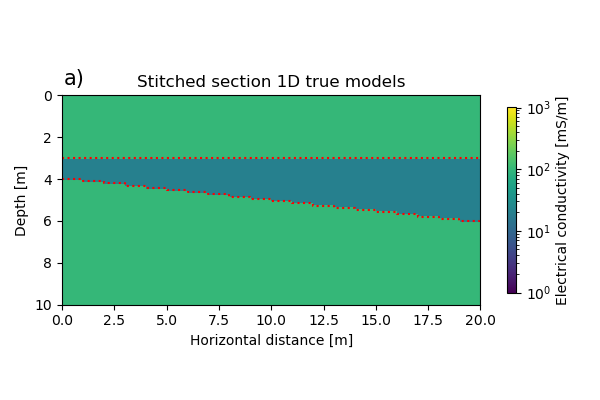

In [4]:
model_true_grid = PlotModelCond_3lay(sigmas_true, depths_true[:,1:])
xx = np.linspace(0,npos+1,npos+1, endpoint=False)
plt.step(np.hstack((xx, xx[-1])), np.hstack((depths_true[0,1],depths_true[:,1], depths_true[-2,1])), ':r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depths_true[0,2],depths_true[:,2], depths_true[-2,2])), ':r')
plt.title('Stitched section 1D true models')
plt.text(0.1,-0.5,'a)', color='k',fontsize=15)
plt.tight_layout()

In [5]:
#fig, ax = plt.subplots(3,2)
#PlotData(data_true, ax=ax)
#PlotData(data_true_noise2, ax=ax)

In [44]:
# Create forward modeller class

class EMforward_3lay(pg.Modelling):
    def __init__(self):
        """Initialize the model."""
        super().__init__()        
    def response(self, x):
        sig1 = x[0]
        sig2 = x[1]
        sig3 = x[2]
        thk1 = x[3]
        thk2 = x[4]
        if (thk1+thk2) > 10:
            thk1 = 2
            thk2 = 3
        Z = EMforward3lay(sig1, sig2, sig3, thk1, thk2, height=0.47)                           
        return Z               
    def createStartModel(self, dataVals):
        thk_ini = [2,3]
        sig_ini = [1/20, 1/20, 1/20]
        x0 = sig_ini + thk_ini
        return np.array(x0)

In [26]:
# Initialize the forward modelling class
EMf_3lay = EMforward_3lay()

# Relative error array
error = 1e-3 # introduce here the error you want to test
relativeError = np.ones_like(data_true[0]) * error

# Define inversion transformations

transData = pg.trans.TransLog() # log transformation for data
transModel = pg.trans.TransLog()  # log-transform ensures thk and res >0

# Create inversion
invEM = pg.Inversion()
invEM.setForwardOperator(EMf_3lay)

invEM.transModel = transModel
invEM.transData = transData

# Start inversion

model_est_n2 = np.zeros_like(model_true)
#chi2hist = [] # empty array to store the chi2 history
#modelhist = [] # empty array to store the model history

# Perform inversion for each 1D model per position in stitched section
for pos in range(npos):
    dataE = data_true_noise2[pos].copy()
    dataE *= np.random.randn(len(dataE)) * relativeError + 1.0
    model_est_pos = invEM.run(dataE, relativeError, verbose=False, lam=10, maxIter=40)
    #chi2hist.append(invEM.chi2History)
    #modelhist.append(invEM.modelHistory)
    model_est_n2[pos] = model_est_pos

15/08/23 - 17:07:18 - pyGIMLi - INFO - Created startmodel from forward operator: [0.05 0.05 0.05 2.   3.  ]
15/08/23 - 17:07:19 - pyGIMLi - INFO - Created startmodel from forward operator: [0.05 0.05 0.05 2.   3.  ]
15/08/23 - 17:07:20 - pyGIMLi - INFO - Created startmodel from forward operator: [0.05 0.05 0.05 2.   3.  ]
15/08/23 - 17:07:21 - pyGIMLi - INFO - Created startmodel from forward operator: [0.05 0.05 0.05 2.   3.  ]
15/08/23 - 17:07:22 - pyGIMLi - INFO - Created startmodel from forward operator: [0.05 0.05 0.05 2.   3.  ]
15/08/23 - 17:07:22 - pyGIMLi - INFO - Created startmodel from forward operator: [0.05 0.05 0.05 2.   3.  ]
15/08/23 - 17:07:23 - pyGIMLi - INFO - Created startmodel from forward operator: [0.05 0.05 0.05 2.   3.  ]
15/08/23 - 17:07:24 - pyGIMLi - INFO - Created startmodel from forward operator: [0.05 0.05 0.05 2.   3.  ]
15/08/23 - 17:07:25 - pyGIMLi - INFO - Created startmodel from forward operator: [0.05 0.05 0.05 2.   3.  ]
15/08/23 - 17:07:26 - pyGIML

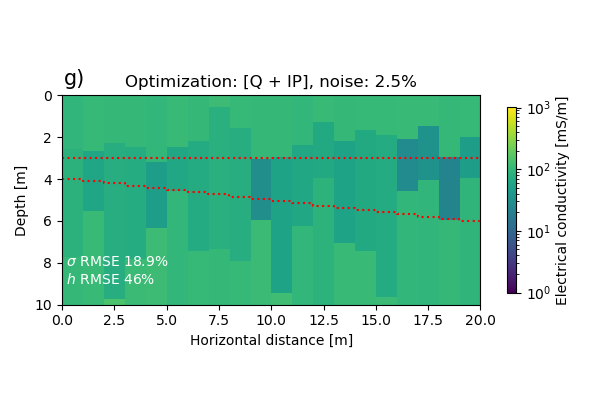

In [27]:
depths_est_n2 = np.zeros_like(depths_true)
sigmas_est_n2 = np.zeros_like(sigmas_true)
depths_est_n2[:,1] = model_est_n2[:,3]
depths_est_n2[:,2] = model_est_n2[:,3] + model_est_n2[:,4]
sigmas_est_n2[:,:] = model_est_n2[:,:3]

RMSE_res = rmse_a(np.log10(np.hstack(sigmas_est_n2)), np.log10(np.hstack(sigmas_true)))
RMSE_thk = rmse_a(np.hstack(depths_est_n2[:,1:]), np.hstack(depths_true[:,1:]))

model_est_grid_n2 = PlotModelCond_3lay(sigmas_est_n2, depths_est_n2[:,1:])
xx = np.linspace(0,npos+1,npos+1, endpoint=False)
plt.step(np.hstack((xx, xx[-1])), np.hstack((depths_true[0,1],depths_true[:,1], depths_true[-2,1])), ':r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depths_true[0,2],depths_true[:,2], depths_true[-2,2])), ':r')
plt.text(0,9,' $\sigma$ RMSE %.3g' %(RMSE_res*100) + '%' 
          +' \n $h$ RMSE %.3g' %(RMSE_thk*100) +'%', color='w')
plt.text(0.1,-0.5,'g)', color='k',fontsize=15)
plt.title('Optimization: [Q + IP], noise: 2.5%')
plt.tight_layout()

Text(0, 0.5, 'Depth [m]')

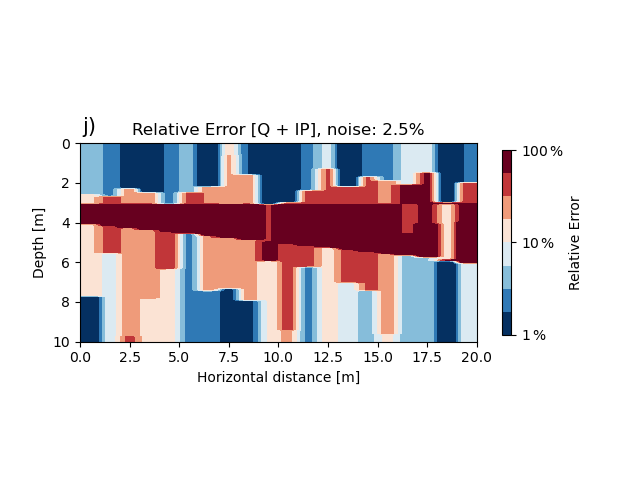

In [28]:
fig, ax = plt.subplots()

error_est = np.abs((model_true_grid-model_est_grid_n2)/model_true_grid)*100+0.1
cf = ax.imshow(np.log10(error_est).T, extent=[0,npos,10,0], vmin=0, vmax=2,
          cmap=plt.cm.get_cmap("RdBu_r", 8))
cbar = fig.colorbar(cf, ax=ax, label=r"Relative Error",  shrink=0.5)
cbar.set_ticks([0, 1, 2])
cbar.ax.set_yticklabels([ r"$1\,\%$",
                         r"$10\,\%$", r"$100\,\%$"])
plt.title('Relative Error [Q + IP], noise: 2.5%')
plt.text(0.1,-0.5,'j)', color='k',fontsize=15)
plt.xlabel('Horizontal distance [m]')
plt.ylabel('Depth [m]')

In [29]:
# Initialize the forward modelling class
EMf_3lay = EMforward_3lay()

# Relative error array
error = 1e-3 # introduce here the error you want to test
relativeError = np.ones_like(data_true[0]) * error

# Define inversion transformations

transData = pg.trans.TransLog() # log transformation for data
transModel = pg.trans.TransLog()  # log-transform ensures thk and res >0

# Create inversion
invEM = pg.Inversion()
invEM.setForwardOperator(EMf_3lay)

invEM.transModel = transModel
invEM.transData = transData

# Start inversion

model_est_n5 = np.zeros_like(model_true)
#chi2hist = [] # empty array to store the chi2 history
#modelhist = [] # empty array to store the model history

# Perform inversion for each 1D model per position in stitched section
for pos in range(npos):
    dataE = data_true_noise5[pos].copy()
    dataE *= np.random.randn(len(dataE)) * relativeError + 1.0
    model_est_pos = invEM.run(dataE, relativeError, verbose=False, lam=10, maxIter=40)
    #chi2hist.append(invEM.chi2History)
    #modelhist.append(invEM.modelHistory)
    model_est_n5[pos] = model_est_pos

15/08/23 - 17:08:08 - pyGIMLi - INFO - Created startmodel from forward operator: [0.05 0.05 0.05 2.   3.  ]
15/08/23 - 17:08:09 - pyGIMLi - INFO - Created startmodel from forward operator: [0.05 0.05 0.05 2.   3.  ]
15/08/23 - 17:08:10 - pyGIMLi - INFO - Created startmodel from forward operator: [0.05 0.05 0.05 2.   3.  ]
15/08/23 - 17:08:10 - pyGIMLi - INFO - Created startmodel from forward operator: [0.05 0.05 0.05 2.   3.  ]
15/08/23 - 17:08:11 - pyGIMLi - INFO - Created startmodel from forward operator: [0.05 0.05 0.05 2.   3.  ]
15/08/23 - 17:08:12 - pyGIMLi - INFO - Created startmodel from forward operator: [0.05 0.05 0.05 2.   3.  ]
15/08/23 - 17:08:13 - pyGIMLi - INFO - Created startmodel from forward operator: [0.05 0.05 0.05 2.   3.  ]
15/08/23 - 17:08:13 - pyGIMLi - INFO - Created startmodel from forward operator: [0.05 0.05 0.05 2.   3.  ]
15/08/23 - 17:08:14 - pyGIMLi - INFO - Created startmodel from forward operator: [0.05 0.05 0.05 2.   3.  ]
15/08/23 - 17:08:15 - pyGIML

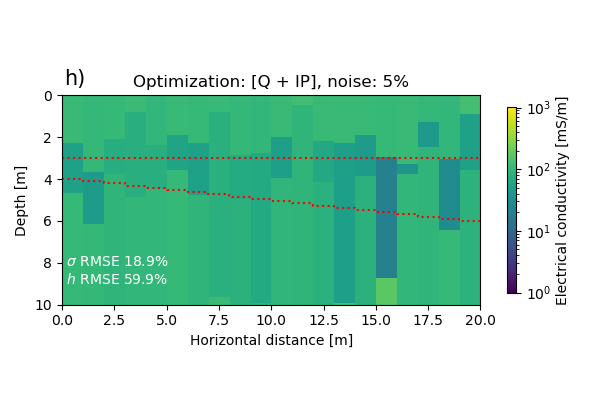

In [30]:
depths_est_n5 = np.zeros_like(depths_true)
sigmas_est_n5 = np.zeros_like(sigmas_true)
depths_est_n5[:,1] = model_est_n5[:,3]
depths_est_n5[:,2] = model_est_n5[:,3] + model_est_n5[:,4]
sigmas_est_n5[:,:] = model_est_n5[:,:3]

RMSE_res = rmse_a(np.log10(np.hstack(sigmas_est_n5)), np.log10(np.hstack(sigmas_true)))
RMSE_thk = rmse_a(np.hstack(depths_est_n5[:,1:]), np.hstack(depths_true[:,1:]))

model_est_grid_n5 = PlotModelCond_3lay(sigmas_est_n5, depths_est_n5[:,1:])
xx = np.linspace(0,npos+1,npos+1, endpoint=False)
plt.step(np.hstack((xx, xx[-1])), np.hstack((depths_true[0,1],depths_true[:,1], depths_true[-2,1])), ':r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depths_true[0,2],depths_true[:,2], depths_true[-2,2])), ':r')
plt.text(0,9,' $\sigma$ RMSE %.3g' %(RMSE_res*100) + '%' 
          +' \n $h$ RMSE %.3g' %(RMSE_thk*100) +'%', color='w')
plt.text(0.1,-0.5,'h)', color='k',fontsize=15)
plt.title('Optimization: [Q + IP], noise: 5%')
plt.tight_layout()

Text(0, 0.5, 'Depth [m]')

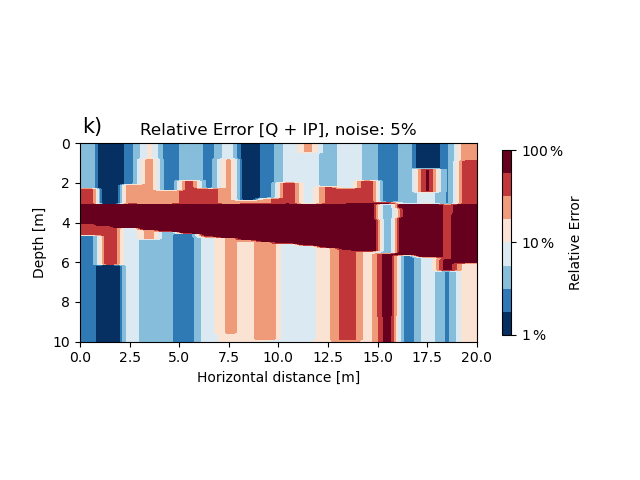

In [31]:
fig, ax = plt.subplots()

error_est = np.abs((model_true_grid-model_est_grid_n5)/model_true_grid)*100+0.1
cf = ax.imshow(np.log10(error_est).T, extent=[0,npos,10,0], vmin=0, vmax=2,
          cmap=plt.cm.get_cmap("RdBu_r", 8))
cbar = fig.colorbar(cf, ax=ax, label=r"Relative Error",  shrink=0.5)
cbar.set_ticks([0, 1, 2])
cbar.ax.set_yticklabels([ r"$1\,\%$",
                         r"$10\,\%$", r"$100\,\%$"])
plt.title('Relative Error [Q + IP], noise: 5%')
plt.text(0.1,-0.5,'k)', color='k',fontsize=15)
plt.xlabel('Horizontal distance [m]')
plt.ylabel('Depth [m]')

In [53]:
# Create forward modeller class

class EMforward_3lay(pg.Modelling):
    def __init__(self):
        """Initialize the model."""
        super().__init__()        
    def response(self, x):
        sig1 = x[0]
        sig2 = x[1]
        sig3 = x[2]
        thk1 = x[3]
        thk2 = x[4]
        if (thk1+thk2) >= 10:
            thk1 = 2
            thk2 = 3
        Z = EMforward3lay(sig1, sig2, sig3, thk1, thk2, height=0.47)                           
        return Z               
    def createStartModel(self, dataVals):
        thk_ini = [3,2]
        sig_ini = [1/50, 1/50, 1/50]
        x0 = sig_ini + thk_ini
        return np.array(x0)

In [54]:
# Initialize the forward modelling class
EMf_3lay = EMforward_3lay()

# Relative error array
error = 1e-3 # introduce here the error you want to test
relativeError = np.ones_like(data_true[0]) * error

# Define inversion transformations

transData = pg.trans.TransLog() # log transformation for data
transModel = pg.trans.TransLog()  # log-transform ensures thk and res >0

# Create inversion
invEM = pg.Inversion()
invEM.setForwardOperator(EMf_3lay)

invEM.transModel = transModel
invEM.transData = transData

# Start inversion

model_est_n10 = np.zeros_like(model_true)
#chi2hist = [] # empty array to store the chi2 history
#modelhist = [] # empty array to store the model history

# Perform inversion for each 1D model per position in stitched section
for pos in range(npos):
    dataE = data_true_noise10[pos].copy()
    dataE *= np.random.randn(len(dataE)) * relativeError + 1.0
    model_est_pos = invEM.run(dataE, relativeError, verbose=False, lam=10, maxIter=40)
    #chi2hist.append(invEM.chi2History)
    #modelhist.append(invEM.modelHistory)
    model_est_n10[pos] = model_est_pos

15/08/23 - 17:17:58 - pyGIMLi - INFO - Created startmodel from forward operator: [0.02 0.02 0.02 3.   2.  ]
15/08/23 - 17:18:00 - pyGIMLi - INFO - Created startmodel from forward operator: [0.02 0.02 0.02 3.   2.  ]
15/08/23 - 17:18:01 - pyGIMLi - INFO - Created startmodel from forward operator: [0.02 0.02 0.02 3.   2.  ]
15/08/23 - 17:18:02 - pyGIMLi - INFO - Created startmodel from forward operator: [0.02 0.02 0.02 3.   2.  ]
15/08/23 - 17:18:03 - pyGIMLi - INFO - Created startmodel from forward operator: [0.02 0.02 0.02 3.   2.  ]
15/08/23 - 17:18:04 - pyGIMLi - INFO - Created startmodel from forward operator: [0.02 0.02 0.02 3.   2.  ]
15/08/23 - 17:18:05 - pyGIMLi - INFO - Created startmodel from forward operator: [0.02 0.02 0.02 3.   2.  ]
15/08/23 - 17:18:06 - pyGIMLi - INFO - Created startmodel from forward operator: [0.02 0.02 0.02 3.   2.  ]
15/08/23 - 17:18:07 - pyGIMLi - INFO - Created startmodel from forward operator: [0.02 0.02 0.02 3.   2.  ]
15/08/23 - 17:18:09 - pyGIML

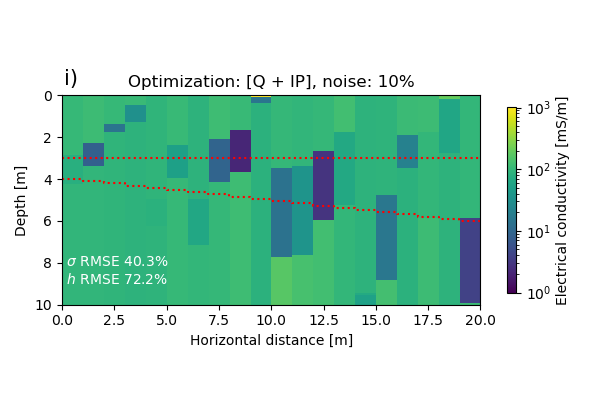

In [55]:
depths_est_n10 = np.zeros_like(depths_true)
sigmas_est_n10 = np.zeros_like(sigmas_true)
depths_est_n10[:,1] = model_est_n10[:,3]
depths_est_n10[:,2] = model_est_n10[:,3] + model_est_n10[:,4]
sigmas_est_n10[:,:] = model_est_n10[:,:3]

RMSE_res = rmse_a(np.log10(np.hstack(sigmas_est_n10)), np.log10(np.hstack(sigmas_true)))
RMSE_thk = rmse_a(np.hstack(depths_est_n10[:,1:]), np.hstack(depths_true[:,1:]))

model_est_grid_n10 = PlotModelCond_3lay(sigmas_est_n10, depths_est_n10[:,1:])
xx = np.linspace(0,npos+1,npos+1, endpoint=False)
plt.step(np.hstack((xx, xx[-1])), np.hstack((depths_true[0,1],depths_true[:,1], depths_true[-2,1])), ':r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depths_true[0,2],depths_true[:,2], depths_true[-2,2])), ':r')
plt.text(0,9,' $\sigma$ RMSE %.3g' %(RMSE_res*100) + '%' 
          +' \n $h$ RMSE %.3g' %(RMSE_thk*100) +'%', color='w')
plt.text(0.1,-0.5,'i)', color='k',fontsize=15)
plt.title('Optimization: [Q + IP], noise: 10%')
plt.tight_layout()

Text(0, 0.5, 'Depth [m]')

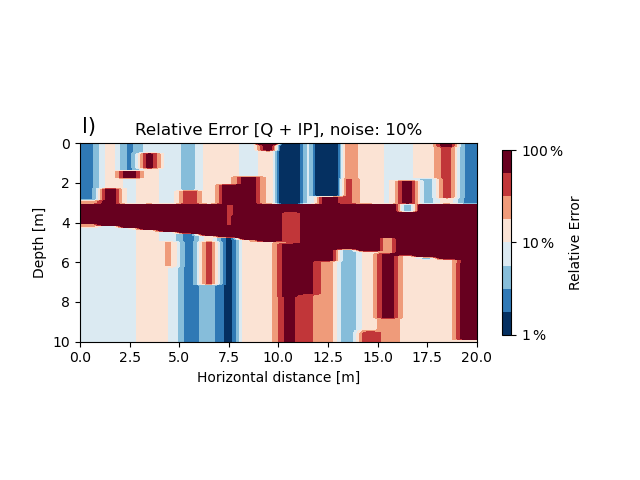

In [56]:
fig, ax = plt.subplots()

error_est = np.abs((model_true_grid-model_est_grid_n10)/model_true_grid)*100+0.1
cf = ax.imshow(np.log10(error_est).T, extent=[0,npos,10,0], vmin=0, vmax=2,
          cmap=plt.cm.get_cmap("RdBu_r", 8))
cbar = fig.colorbar(cf, ax=ax, label=r"Relative Error",  shrink=0.5)
cbar.set_ticks([0, 1, 2])
cbar.ax.set_yticklabels([ r"$1\,\%$",
                         r"$10\,\%$", r"$100\,\%$"])
plt.title('Relative Error [Q + IP], noise: 10%')
plt.text(0.1,-0.5,'l)', color='k',fontsize=15)
plt.xlabel('Horizontal distance [m]')
plt.ylabel('Depth [m]')